<a href="https://colab.research.google.com/github/dalexa10/Numerical_Methods_PDEs/blob/main/Firedrake_Tutorial/helmholtz_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"

--2023-04-03 16:54:13--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4468 (4.4K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.36K  --.-KB/s    in 0s      

2023-04-03 16:54:13 (47.7 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4468/4468]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/fc227ba/rele

In [2]:
# This magic makes plots appear in the browser
import matplotlib.pyplot as plt

# The positive-definite Helmholtz equation

We start by considering the symmetric positive definite "Helmholtz" problem on a unit square domain $\Omega$ with boundary $\Gamma$. We seek to find the solution $u \in V$, where $V$ is some finite element space, satisfying the boundary value problem:

$$ -\nabla^2 u + u = f \text{ on } \Omega = [0, 1] \times [0, 1], \\
\nabla u \cdot \vec{n} = 0 \text{ on } \Gamma, $$

where $\vec{n}$ is the outward-pointing unit normal to $\Gamma$ and $f \in V$ is a known source function.  Note that the Laplacian and mass terms have opposite signs, which makes this equation much more benign than the symmetric, indefinite operator $(\nabla^2 + I)$.

Now, we write the problem in its variational form by multiplying by a test function $v \in V$ and integrating by parts over the domain $\Omega$:

$$ \int_\Omega \nabla u\cdot\nabla v  + uv\ \mathrm{d}x = \int_\Omega
vf\ \mathrm{d}x + \underbrace{\int_\Gamma v \nabla u \cdot \vec{n}\, \mathrm{d} s}_{=0}. $$

Note that the boundary condition has been enforced weakly by removing the surface integral term resulting from the integration by parts.

We will now proceed to solve this problem using an $H^1$ conforming method. The full finite element problem reads as follows: find $u \in V$ such that:

$$ \int_\Omega \nabla u\cdot\nabla v  + uv\ \mathrm{d}x = \int_\Omega
vf\ \mathrm{d}x, \text{ for all } v \in V. $$

We can choose the source function $f$, so lets take it to be:

$$ f(x, y) = (1.0 + 8.0\pi^2)\cos(2\pi x)\cos(2\pi y). $$

This conveniently yields the analytical solution:

$$ u(x, y) = \cos(2\pi x)\cos(2\pi y). $$

However, we wish to employ this as an example for the finite element method, so lets go ahead and produce a numerical solution. First, we need our domain $\Omega$. Firedrake can read meshes from a number of popular mesh generators.  In addition, it provides utility functions to create many "standard" meshes in one, two, and three dimensions.  For a complete list of provided meshes, we can peruse the [online Firedrake documentation](http://firedrakeproject.org/firedrake.html#module-firedrake.utility_meshes).  Unsurprisingly, amongst them is a `UnitSquareMesh`.

To start, we must make Firedrake available in the notebook.  It is available as a normal Python package, named `firedrake`.  To save on typing, we will import all of the public API into the current namespace

In [3]:
from firedrake import *

Now we want to define our mesh.  We already know that `UnitSquareMesh` will give us an appropriate mesh of the domain $\Omega$, but what are the arguments to the constructor?  The user-facing API is usually well-documented, and we can access this information via Python using the builtin `help` command:

In [4]:
help(UnitSquareMesh)

Help on cython_function_or_method in module firedrake.utility_meshes:

UnitSquareMesh(nx, ny, reorder=None, diagonal='left', quadrilateral=False, distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x7f501cbaaba0>, name='firedrake_default', distribution_name=None, permutation_name=None)
    Generate a unit square mesh
    
    :arg nx: The number of cells in the x direction
    :arg ny: The number of cells in the y direction
    :kwarg quadrilateral: (optional), creates quadrilateral mesh.
    :kwarg reorder: (optional), should the mesh be reordered
    :kwarg distribution_parameters: options controlling mesh
           distribution, see :func:`.Mesh` for details.
    :kwarg comm: Optional communicator to build the mesh on.
    :kwarg name: Optional name of the mesh.
    :kwarg distribution_name: the name of parallel distribution used
           when checkpointing; if `None`, the name is automatically
           generated.
    :kwarg permutation_name: the name of entity 

In [5]:
# In the notebook, we can also use a special "?" magic to pop up a help box
?UnitSquareMesh

We'll get to what some of the other arguments mean later, but right now we see that the first two allow us to specify the number of cells in the x-, and y-directions respectively.

In [6]:
mesh = UnitSquareMesh(10, 10)

What does this mesh look like?  Firedrake has some built in plotting of meshes and functions, using matplotlib (that's why we had the magic matplotlib line at the top of this notebook).
The built-in plotting functions correspond with those from matplotlib, like [tripcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.tripcolor.html#matplotlib.pyplot.tripcolor), [tricontour](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.tricontour.html#matplotlib.pyplot.tricontour), [tricontourf](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.tricontourf.html#matplotlib.pyplot.tricontourf).
For this plot, we'll also add a legend that will show us what the numeric ID is of each boundary segment.
Visualizing the mesh with a legend is helpful when you have to apply boundary conditions to part of a mesh and forget how the segments are numbered.

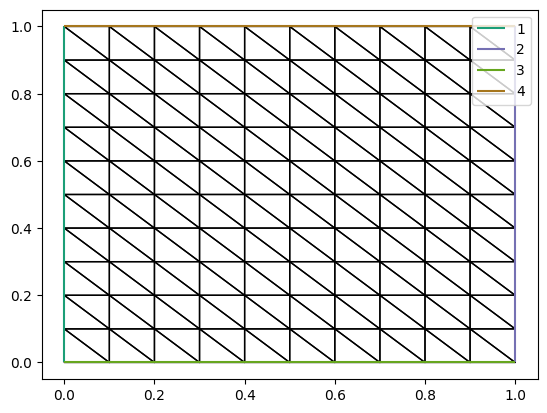

In [7]:
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend();
plt.show()

Having selected a discretisation of our domain $\Omega$, we need to decide on the finite-dimensional function space $V_h \subset V$ in which we’d like to solve the problem. Since we are using an $H^1$ conforming method, the space of continuous piecewise defined polynomials of a fixed degree will be appropriate. As an example, let us use the space of piecewise linear polynomials that are continuous between elements:

In [8]:
V = FunctionSpace(mesh, "Lagrange", 1)

We now define the problem.  We'll create the _symbolic_ objects that correspond to test and trial spaces, and the linear and bilinear forms in our problem.

In [9]:
u = TrialFunction(V)
v = TestFunction(V)

For the right hand side forcing, we'll use a UFL expression, incorporating information about the $x$ and $y$ coordinates.  We make a symbolic representation of the coordinates in our mesh (these will be evaluated when we actually do the calculation).

In [10]:
x, y = SpatialCoordinate(mesh)
f = (1 + 8*pi*pi)*cos(2*pi*x)*cos(2*pi*y)

We can now define the bilinear and linear forms for the left and right hand sides of our equation respectively in UFL:

In [11]:
a = (dot(grad(v), grad(u)) + v * u) * dx
L = f * v * dx

Finally we are now ready to solve the equation. We define $u_h$ to be a function holding the solution:

In [12]:
uh = Function(V)

Since we know that the Helmholtz equation defines a symmetric problem, we instruct PETSc to employ the conjugate gradient method. We do not consider preconditioning, for now.

In [13]:
solve(a == L, uh, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'})

Let's have a look at the solution.
You can use all the same arguments as for the matplotlib tripcolor function for things like changing the colormap, the min and max values, and so forth.

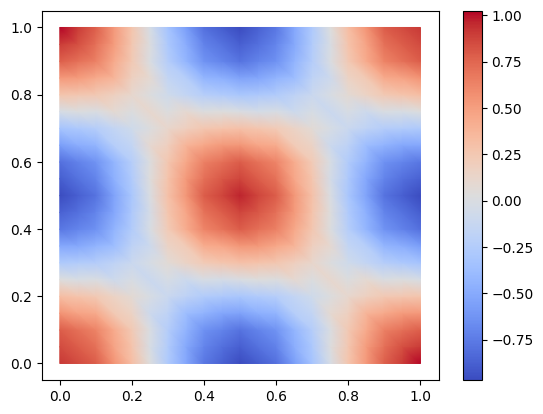

In [14]:
fig, axes = plt.subplots()
collection = tripcolor(uh, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

Since we chose a forcing function for which we know the exact solution, we can compute the difference between the approximate solution and the exact solution interpolated to the space of the approximate solution.  Remember, that the exact solution $u^* = \cos(2\pi x)\cos(2\pi y)$.

In [15]:
u_exact = cos(2*pi*x)*cos(2*pi*y)

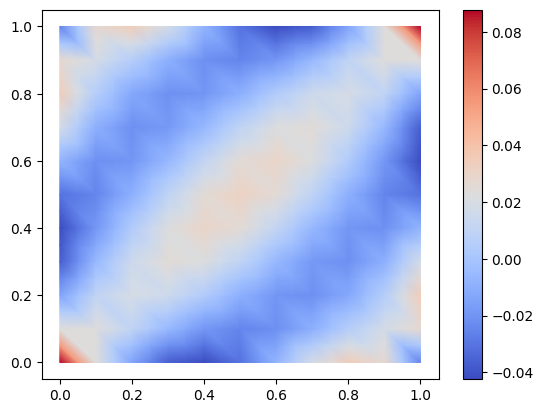

In [16]:
difference = assemble(interpolate(u_exact, V) - uh)
fig, axes = plt.subplots()
collection = tripcolor(difference, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

# Exercises

## Exercise 1: 

### 1a: use a higher approximation degree

Solve the same problem, only this time, use a piecewise quadratic approximation space.

- Hint: check the help for `FunctionSpace` to see how to specify the degree.

### 1b: use a quadrilateral mesh

Solve the same problem, but using quadrilateral, rather than triangular, cells.

- Hint 1: check the help for `UnitSquareMesh` to see how to make a quadrilateral mesh
- Hint 2: To specify a piecewise continuous space on quadrilaterals, use the family name `"Q"`.

Find information about FunctionSpace 

In [18]:
help(FunctionSpace)

Help on cython_function_or_method in module firedrake.functionspace:

FunctionSpace(mesh, family, degree=None, name=None, vfamily=None, vdegree=None)
    Create a :class:`.FunctionSpace`.
    
    :arg mesh: The mesh to determine the cell from.
    :arg family: The finite element family.
    :arg degree: The degree of the finite element.
    :arg name: An optional name for the function space.
    :arg vfamily: The finite element in the vertical dimension
        (extruded meshes only).
    :arg vdegree: The degree of the element in the vertical dimension
        (extruded meshes only).
    
    The ``family`` argument may be an existing
    :class:`ufl.FiniteElementBase`, in which case all other arguments
    are ignored and the appropriate :class:`.FunctionSpace` is returned.



Change polynomial degree to 2

In [20]:
V2 = FunctionSpace(mesh, "Lagrange", 2)

In [21]:
u2 = TrialFunction(V)
v2 = TestFunction(V)

In [22]:
x2, y2 = SpatialCoordinate(mesh)
f = (1 + 8*pi*pi)*cos(2*pi*x2)*cos(2*pi*y2)

In [23]:
a = (dot(grad(v2), grad(u2)) + v2 * u2) * dx
L = f * v2 * dx

## Exercise 2: convergence of the method
For solutions with sufficient smoothness (like the choice we have here), this method with a piecewise linear approximation space should converge in the $L_2$ error with rate $\mathcal{O}(h^{-2})$, where $h$ is the typical mesh spacing.  Confirm this for the example in question by computing the $L_2$ error in the solution for a sequence of finer and finer meshes.

- Hint 1: You can compute errors using [errornorm](http://firedrakeproject.org/firedrake.html#firedrake.norms.errornorm)
- Hint 2: If the error is $\mathcal{O}(h^{-2})$ then $\log_2 (e_H/e_h) \approx 2$.
  The Python module `math` contains an implementation of `log`.
  
### What works better?  Mesh refinement, or increasing the approximation degree?

Instead of (or as well as!) refining the mesh, we can increase the degree of the approximating polynomial space.

To help, here's the complete problem setup.

In [ ]:
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "Lagrange", 1)
u = TrialFunction(V)
v = TestFunction(V)
x, y = SpatialCoordinate(mesh)
f = (1 + 8*pi*pi)*cos(2*pi*x)*cos(2*pi*y)
a = (dot(grad(v), grad(u)) + v * u) * dx
L = f * v * dx

uh = Function(V)
solve(a == L, uh, solver_parameters={'ksp_type': 'cg',
                                     'pc_type': 'none'})

u_exact = cos(2*pi*x)*cos(2*pi*y)

# Part II: inhomogeneous Neuman conditions

Let us recall again the statement of our problem.  We seek $u \in V$ satisfying

$$ -\nabla^2 u + u = f \text{ on } \Omega = [0, 1] \times [0, 1], \\
\nabla u \cdot \vec{n} = 0 \text{ on } \Gamma. $$

However, we will not always want to constrain the normal derivative on the boundary to be zero.  Let's consider the modification:

$$ -\nabla^2 u + u = f \text{ on } \Omega = [0, 1] \times [0, 1], \\
\nabla u \cdot \vec{n} = g = 1 \text{ on } \Gamma_1, \\
\nabla u \cdot \vec{n} = 0 \text{ on } \Gamma \setminus \Gamma_1,$$

where $\Gamma_1$ is the boundary $x = 0$.

As previously, we introduce a test function $v \in V$, multiply and integrate.  After integrating by parts, we obtain

$$ \int_\Omega \nabla u\cdot\nabla v  + uv\ \mathrm{d}x = \int_\Omega
vf\ \mathrm{d}x + \underbrace{\int_{\Gamma\setminus \Gamma_1} v \nabla u \cdot \vec{n}\, \mathrm{d} s}_{=0} + \int_{\Gamma_1} v \nabla u \cdot \vec{n}\,\mathrm{d} s.$$

The first surface integral over $\Gamma \setminus \Gamma_1$ vanishes, since $\nabla u \cdot \vec{n} = 0$.  The second, however, does not.  Substituting the boundary value we obtain

$$ \int_\Omega \nabla u\cdot\nabla v  + uv\ \mathrm{d}x = \int_\Omega
vf\ \mathrm{d}x + \int_{\Gamma_1} v g\,\mathrm{d} s.$$

We see that the linear form for the right hand side has gained an integral over part of the boundary (some of its *exterior* facets).  We've already seen how to express integrals over the cells of the domain, using `dx`.  Unsurprisingly, we can also write integrals over the boundary, for which we use the `ds` measure.

There's one final wrinkle, just as `dx` integrates over all the cells in the mesh, `ds` integrates over all the exterior facets of the mesh.  Firedrake uses *mesh markers* to select which parts of the mesh the integral measure should integrate over.  These are integers (or tuples thereof) that have some meaning for the mesh.  Most external mesh generators will have some way of marking meshes in this way.  For the utility meshes, the docstring indicates which markers correspond to which parts of the mesh.  So let's look:

In [ ]:
?UnitSquareMesh

Recall that we want to specify a non-zero boundary value when $x = 0$.  This corresponds to the mesh marker `1`.  Our full problem specification is now

In [ ]:
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "Lagrange", 1)
u = TrialFunction(V)
v = TestFunction(V)
x, y = SpatialCoordinate(mesh)
f = (1 + 8*pi*pi)*cos(2*pi*x)*cos(2*pi*y)
a = (dot(grad(v), grad(u)) + v * u) * dx

Up to now, everything is as before.  We now define the right hand side.  A bare `ds` would integrate over all exterior facets, we select the facets corresponding to $x = 0$ by specifying the appropriate mesh marker.

In [ ]:
g = Constant(1)
L = f*v*dx + g*v*ds(1)

Now to solve the problem

In [ ]:
uh = Function(V)
solve(a == L, uh, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'})

Now plot your solution.